In [1]:
import xgboost
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, f1_score
from scipy.stats import boxcox
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from xgboost import XGBRegressor, XGBClassifier, Booster
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope

In [2]:
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, f1_score, fbeta_score, mean_squared_error
def classification_report_with_scores(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    f1 = f1_score(y_true, y_pred)
    f2 = fbeta_score(y_true, y_pred, beta=2)
    AUC = roc_auc_score(y_true, y_pred)
    cls_report = classification_report(y_true, y_pred)

    # Append additional metrics to classification report
    cls_report = f'\nAccuracy: {accuracy:.3f}' \
                 f'\nFalse Positive Rate: {fpr:.3f}' \
                 f'\nFalse Negative Rate: {fnr:.3f}' \
                 f'\nPrecision: {precision:.3f}' \
                 f'\nRecall: {recall:.3f}' \
                 f'\nRMSE:{rmse:.3f}' \
                 f'\nF1-Score:{f1:.3f}' \
                 f'\nF2-Score:{f2:.3f}' \
                 f'\nROC_AUC_Score:{AUC:.3f}' + \
                 f'\n{cls_report}'

    return cls_report

In [4]:
X_train_2=pd.read_parquet('X_train_standard_data.gzip.parquet')
X_test_2=pd.read_parquet('X_test_standard_data.gzip.parquet')
y_train_2=pd.read_parquet('y_train_data.gzip.parquet')
y_test_2=pd.read_parquet('y_test_data.gzip.parquet')

In [5]:
rfr = RandomForestRegressor(n_jobs=-1)

In [6]:
rfr.fit(X_train_2, y_train_2)

C:\Users\fight\AppData\Local\Temp\ipykernel_113268\1600769629.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train_2, y_train_2)


RandomForestRegressor(n_jobs=-1)

In [7]:
preds = rfr.predict(X_test_2)

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
sigmoid_preds = sigmoid(preds)

In [10]:
estimated_arr = np.where(sigmoid_preds > 0.5, 1, 0)

In [11]:
print(classification_report_with_scores(y_test_2, estimated_arr))


Accuracy: 0.640
False Positive Rate: 0.568
False Negative Rate: 0.005
Precision: 0.507
Recall: 0.995
RMSE:0.600
F1-Score:0.672
F2-Score:0.835
ROC_AUC_Score:0.714
              precision    recall  f1-score   support

           0       0.99      0.43      0.60     24811
           1       0.51      1.00      0.67     14588

    accuracy                           0.64     39399
   macro avg       0.75      0.71      0.64     39399
weighted avg       0.81      0.64      0.63     39399



In [16]:
space_rf = {
    'n_estimators': scope.int(hp.uniform('n_estimators', 100, 1000)),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 30)),
    'min_samples_split': scope.int(hp.uniform('min_samples_split', 1, 20)),
    'min_samples_leaf': scope.int(hp.uniform('min_samples_leaf', 1,  20)),
    'criterion': 'friedman_mse',
    'n_jobs': -1,
    'max_features': 9
}

def objective_rf(params):
    rfr = RandomForestRegressor(**params)
    rfr.fit(X_train_2, np.ravel(y_train_2))
    preds = rfr.predict(X_test_2)
    preds = sigmoid(preds)
    preds = np.where(preds > 0.5, 1, 0)
    f1 = f1_score(np.ravel(y_test_2), np.ravel(preds))
    print("SCORE:", f1)
    return {'loss': -f1, 'status': STATUS_OK, 'model': rfr}

In [17]:
trials = Trials()
best = fmin(fn=objective_rf,
             space=space_rf,
             algo=tpe.suggest,
             max_evals=30,
             trials=trials)
print(best)

SCORE:                                                
0.5404263989478949                                    
SCORE:                                                                           
0.5415297807970005                                                               
SCORE:                                                                           
0.5681565877884897                                                               
SCORE:                                                                           
0.5404263989478949                                                               
SCORE:                                                                           
0.5422544373199516                                                               
SCORE:                                                                           
0.5404263989478949                                                               
SCORE:                                                                

In [18]:
best_model = trials.best_trial['result']['model']

In [21]:
X_train, X_test = pd.read_parquet('X_train_standard_data_arcsinh.gzip.parquet'), pd.read_parquet('X_test_standard_data_arcsinh.gzip.parquet')

In [22]:
best_model.fit(X_train, y_train_2)

C:\Users\fight\AppData\Local\Temp\ipykernel_113268\3030110287.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  best_model.fit(X_train, y_train_2)


RandomForestRegressor(criterion='friedman_mse', max_depth=29, max_features=9,
                      min_samples_split=1, n_estimators=447, n_jobs=-1)

In [23]:
preds = best_model.predict(X_test)

In [24]:
sigmoid_preds = sigmoid(preds)

In [25]:
estimated_arr = np.where(sigmoid_preds > 0.5, 1, 0)

In [26]:
print(classification_report_with_scores(y_test_2, estimated_arr))


Accuracy: 0.507
False Positive Rate: 0.783
False Negative Rate: 0.001
Precision: 0.429
Recall: 0.999
RMSE:0.702
F1-Score:0.600
F2-Score:0.789
ROC_AUC_Score:0.608
              precision    recall  f1-score   support

           0       1.00      0.22      0.36     24811
           1       0.43      1.00      0.60     14588

    accuracy                           0.51     39399
   macro avg       0.71      0.61      0.48     39399
weighted avg       0.79      0.51      0.45     39399



In [38]:
import seaborn as sns
data = pd.read_csv('hotel_bookings.csv')
cat_cols = [col for col in data.columns if data[col].dtype in ['object']]

In [39]:
data = data.drop(columns=cat_cols)

In [ ]:

def outlier_removal(data_frame):
    df = data_frame.copy()
    numerical_cols = [_ for _ in data.columns if data[_].dtype in ['float64', 'int64']]
    for col in numerical_cols:
        x = mstats.winsorize(df[f'{col}'], limits=[0.05,0.05])
        df[f'{col}'] = pd.DataFrame(x)
    return df

In [42]:
ss = StandardScaler()
for col in data.columns:
    data[col] = ss.fit_transform(pd.DataFrame(data[col]))

In [43]:
data

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
0,-0.76704,2.227051,-1.634768,-0.012141,-1.685297,-0.928890,-1.310240,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,4.260101,NaN,NaN,-0.131924,-2.015038,-0.254873,-0.720694
1,-0.76704,5.923385,-1.634768,-0.012141,-1.685297,-0.928890,-1.310240,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,5.793131,NaN,NaN,-0.131924,-2.015038,-0.254873,-0.720694
2,-0.76704,-0.907814,-1.634768,-0.012141,-1.685297,-0.928890,-0.786207,-1.478447,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,NaN,NaN,-0.131924,-0.530935,-0.254873,-0.720694
3,-0.76704,-0.851667,-1.634768,-0.012141,-1.685297,-0.928890,-0.786207,-1.478447,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,1.961711,NaN,-0.131924,-0.530935,-0.254873,-0.720694
4,-0.76704,-0.842309,-1.634768,-0.012141,-1.685297,-0.928890,-0.262174,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,1.383958,NaN,-0.131924,-0.075810,-0.254873,0.540666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,-0.76704,-0.758089,1.192195,0.575875,1.617366,1.073895,1.309924,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,2.774176,NaN,-0.131924,-0.112616,-0.254873,-0.720694
119386,-0.76704,-0.018822,1.192195,0.575875,1.731251,1.073895,1.309924,1.974242,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.701368,NaN,-0.131924,2.445779,-0.254873,1.802026
119387,-0.76704,-0.655153,1.192195,0.575875,1.731251,1.073895,1.309924,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,-0.701368,NaN,-0.131924,1.105733,-0.254873,4.324746
119388,-0.76704,0.046682,1.192195,0.575875,1.731251,1.073895,1.309924,0.247897,-0.260663,-0.081579,-0.18156,-0.10318,-0.091555,-0.338990,0.020823,NaN,-0.131924,0.050833,-0.254873,-0.720694


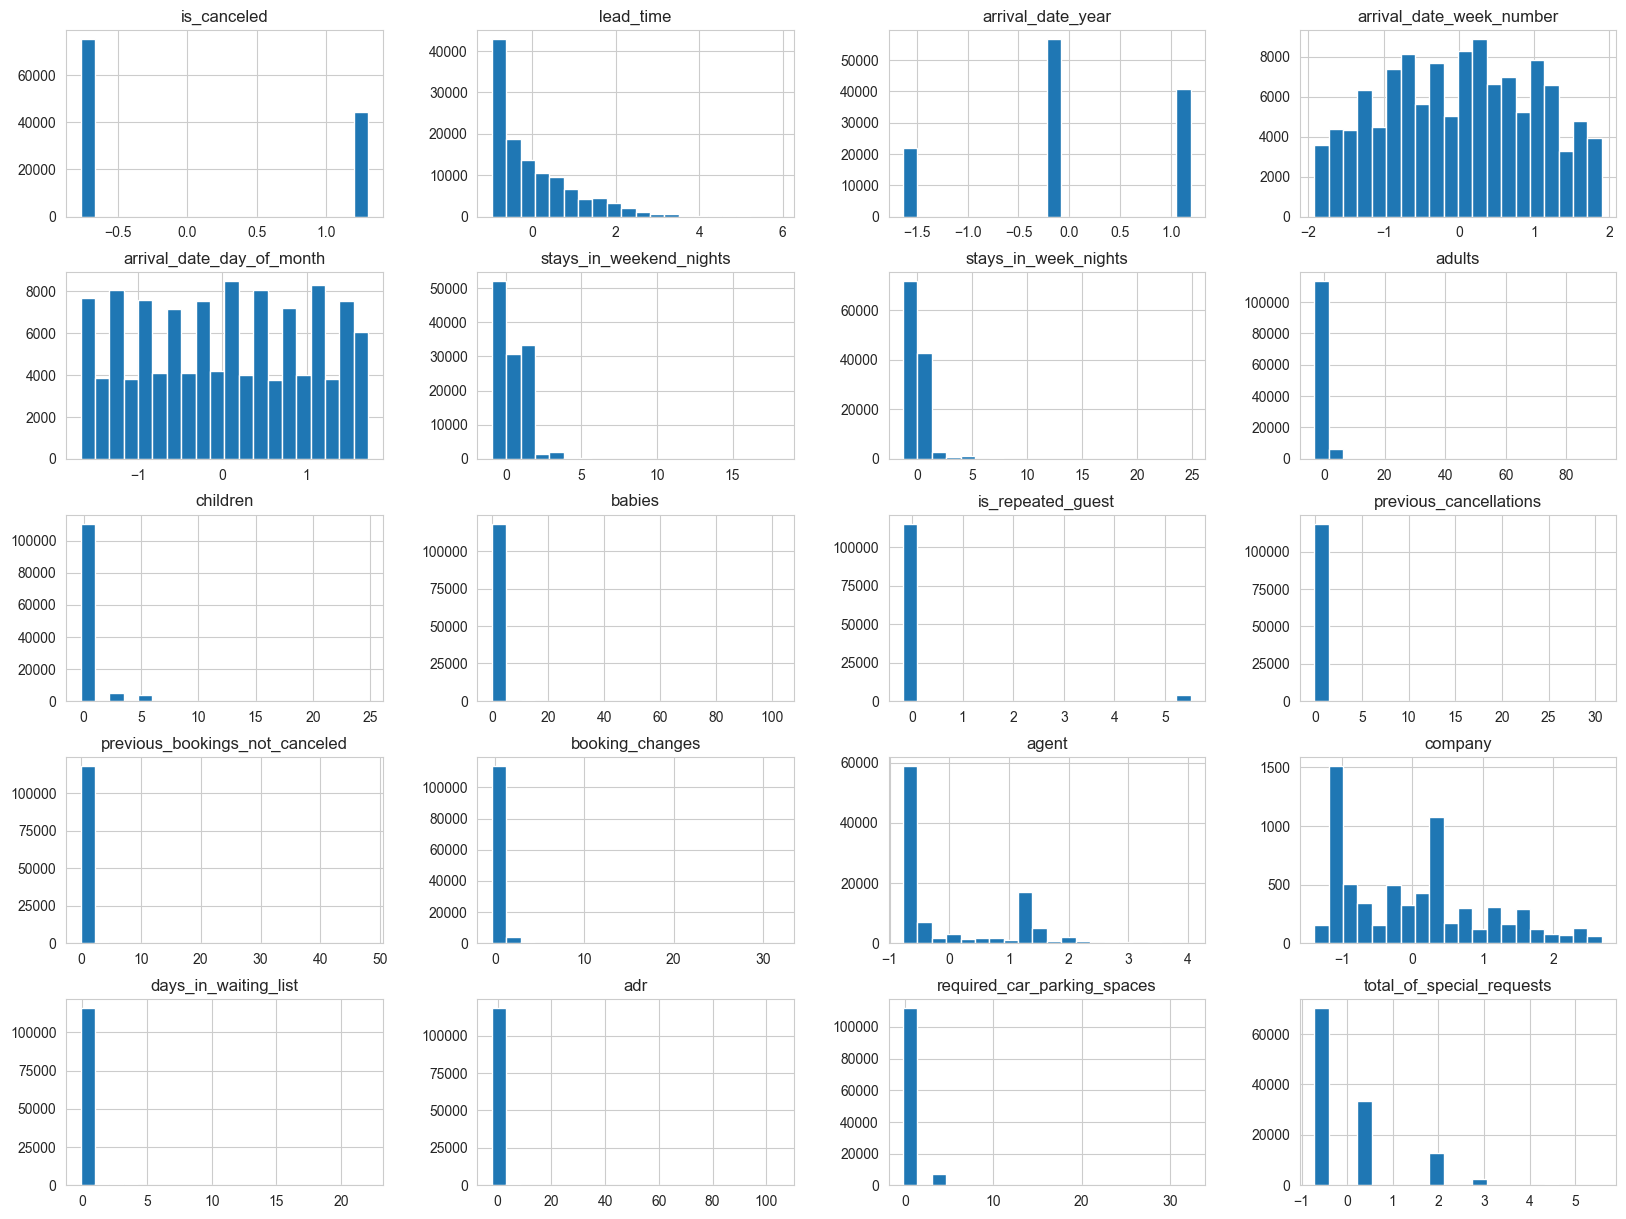

In [44]:
data.hist(bins=20, figsize=(20,15))
plt.show()

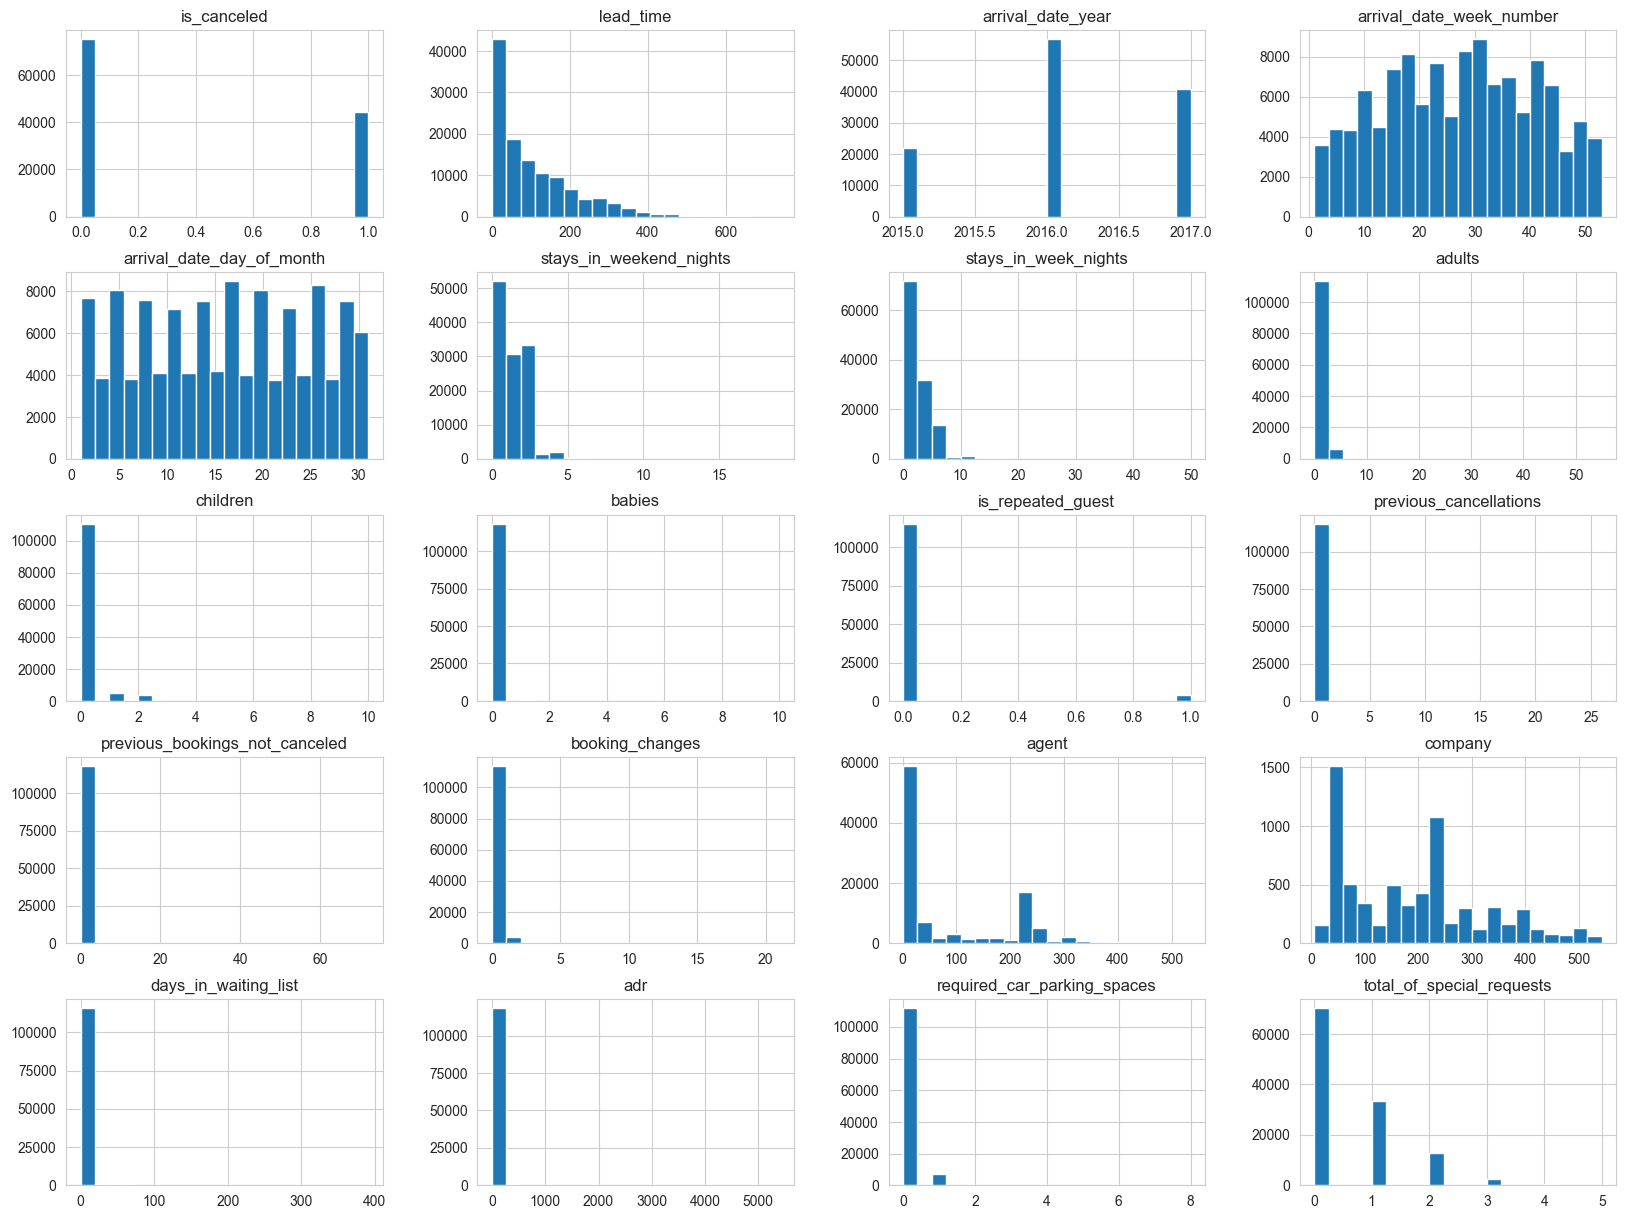

In [37]:
import matplotlib.pyplot as plt
data = pd.read_csv('hotel_bookings.csv')
data.hist(bins=20, figsize=(20,15))
plt.show()